# Boston Crime Prediction and Prevention with ML

Crime prediction and prevention is an approach to assign police resources, social benefits and community workers to the right place at the right time. Knowlege of the origins and spatial distribution of crime provides useful information to purposefully allocate resources. An effective software that detects crime "hot spots" can help not only law enforcement to predict and prevent incidents, but also governemental stakeholders to take effective countermeasures.

While typical publicly available crime datasets contain information about the location, time and type of crimes commited, other factors such as social and economic conditions as well as local facilities can play an important role to determine the origin of crime.

For this project, I would like to create a dataset from different sources taking a few of these factors into account and assess their effectiveness in solving ML problems for crime prediction and prevention.

To accomplish this task I am going to use [crime](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system) and [demographic](https://data.boston.gov/dataset/boston-neighborhoods1) data about Boston provided by [boston.gov](https://data.boston.gov/) as well as other cartographic material from the same website and [openstreetmap.org](https://www.openstreetmap.org/).

The capstone project is outlined as follows:

1. Data preparation, processing and analysis
    - Importing datasets
    - Data processing, cleaning and merging
    - Feature engineering
    - District clustering
1. Exploratory data analysis
    - Statistical analysis
    - Correlation and heat maps
    - Dimensionality reduction   
1. Machine learning models
    - Baseline
    - KNN
    - Decision tree
    - Random forest
    - Summary
1. Discussion
    - Overfitting
    - Feature importance
    - Crime prediction
1. Conclusion

Note: In the following, the crime rate is defined as the number of crimes over the entire period of the dataset. 

## I. Data preparation

### Import datasets

Main datasets:

In [50]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Boston crime
crime = pd.read_csv('data/Boston_Crime_2015-2020.csv', low_memory=False)

# Boston neighborhood demographics
demo = pd.read_excel('data/Boston_Neighborhood_demographics_2013-2017_summary.xlsx')

Datasets with geographical information:

In [51]:
import geopandas as gp
import helperfunctions as hf

# Police district coordinates
police = gp.read_file("data/Boston_Police_Districts.geojson")

# Boston street maps
streets = gp.read_file("data/Boston_Street_Segments.geojson")

# Neighborhoods coordinates
nbrhd = gp.read_file('data/Boston_Neighborhoods.geojson')

# Police station coordinates
pstat = gp.read_file('data/Boston_Police_Stations.geojson')

# Street lights
lights = pd.read_csv('data/Boston_Streetlight_Locations.csv', usecols=[3, 4])

# Entertainement license data
events = hf.read_entertainment_data('data/Boston_Entertainment_licenses_w_detail.csv')

Data from OpenStreetMap

In [52]:
import time
import osmnx as ox
import os
import warnings
ox.config(use_cache=True)

# Source: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/16-download-osm-geospatial-entities.ipynb

# Query
place = 'Boston, Massachusetts'
tags = {'amenity': 
        [
            'bank', 
            'bar',
            'college', 
            'community_centre', 
            'fast_food',
            'nightclub', 
            'prison', 
            'pub', 
            'parking',
            'restaurant',  
            'social_facility', 
            'toilets'
        ]
       }

# Load to GeoDataFrame
warnings.filterwarnings('ignore', category=DeprecationWarning)
osmd = ox.geometries_from_place(place, tags)

### BOSTON CRIME dataset - Analysis and preparation

Analysis of the dataset in terms of values, features, completeness, encoding 

In [53]:
# Show some values
crime.head(3)

INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP        OFFENSE_DESCRIPTION  \
0       TESTTEST2           423                NaN       ASSAULT - AGGRAVATED   
1       S97333701          3301                NaN             VERBAL DISPUTE   
2       S47513131          2647                NaN  THREATS TO DO BODILY HARM   

   DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0  External                       0  2019-10-16 00:00:00  2019     10   
1        C6            915        0  2020-07-18 14:34:00  2020      7   
2       E18            530        0  2020-06-24 10:15:00  2020      6   

  DAY_OF_WEEK  HOUR UCR_PART          STREET        Lat       Long  \
0   Wednesday     0      NaN    RIVERVIEW DR        NaN        NaN   
1    Saturday    14      NaN  MARY BOYLE WAY  42.330813 -71.051368   
2   Wednesday    10      NaN    READVILLE ST  42.239491 -71.135954   

                      Location  
0     (0.00000000, 0.00000000)  
1  (42.33081300, -71.05136800)  
2  (42.23949100, -71.13595400)

In [54]:
# Describe the dataset
crime.describe()

OFFENSE_CODE           YEAR          MONTH           HOUR  \
count  526090.000000  526090.000000  526090.000000  526090.000000   
mean     2332.362409    2017.594330       6.697786      13.072847   
std      1182.702069       1.567051       3.313036       6.350947   
min       111.000000    2015.000000       1.000000       0.000000   
25%      1102.000000    2016.000000       4.000000       9.000000   
50%      3005.000000    2018.000000       7.000000      14.000000   
75%      3201.000000    2019.000000       9.000000      18.000000   
max      3831.000000    2020.000000      12.000000      23.000000   

                 Lat           Long  
count  496096.000000  496096.000000  
mean       42.240725     -70.952131  
std         1.872164       3.028496  
min        -1.000000     -71.203312  
25%        42.296852     -71.097466  
50%        42.325024     -71.077740  
75%        42.348288     -71.062534  
max        42.395042       0.000000

In [55]:
# Observations and features of the Boston crime dataset
print('The Boston crime dataset conatains {:d} observations with {:d} Features'.format(*crime.shape))

The Boston crime dataset conatains 526090 observations with 17 Features


In [56]:
# Features
print('These are: ', ', '.join(crime.columns.to_list()))

These are:  INCIDENT_NUMBER, OFFENSE_CODE, OFFENSE_CODE_GROUP, OFFENSE_DESCRIPTION, DISTRICT, REPORTING_AREA, SHOOTING, OCCURRED_ON_DATE, YEAR, MONTH, DAY_OF_WEEK, HOUR, UCR_PART, STREET, Lat, Long, Location


In [57]:
# Info about the individual features and encoding
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526090 entries, 0 to 526089
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   INCIDENT_NUMBER      526090 non-null  object 
 1   OFFENSE_CODE         526090 non-null  int64  
 2   OFFENSE_CODE_GROUP   426839 non-null  object 
 3   OFFENSE_DESCRIPTION  526090 non-null  object 
 4   DISTRICT             523628 non-null  object 
 5   REPORTING_AREA       526090 non-null  object 
 6   SHOOTING             100997 non-null  object 
 7   OCCURRED_ON_DATE     526090 non-null  object 
 8   YEAR                 526090 non-null  int64  
 9   MONTH                526090 non-null  int64  
 10  DAY_OF_WEEK          526090 non-null  object 
 11  HOUR                 526090 non-null  int64  
 12  UCR_PART             426729 non-null  object 
 13  STREET               504861 non-null  object 
 14  Lat                  496096 non-null  float64
 15  Long             

In [58]:
# Number of NaN entries per feature
crime.isnull().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP      99251
OFFENSE_DESCRIPTION         0
DISTRICT                 2462
REPORTING_AREA              0
SHOOTING               425093
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                99361
STREET                  21229
Lat                     29994
Long                    29994
Location                    0
dtype: int64

Dissection of the features:
* `OFFENSE_CODE_GROUP` is empty from mid 2019 on -> despite we use it as a means to distinguish crimes.
* `DISTRICT` will not be used since police districts are irrelevant for this work
* `REPORTING_AREA` is encoded and can be removed. I could not find the meaning of the codes.
* `SHOOTING` contains many NaN and will not be used as a feature
* `UCR_PART` is an irrelevant internal code
* `Lat` and `Long` are dentrimental but have many NaNs, we have to remove those.
* Even though `Location` has no NaNs, it is a feature derived fom Lat and Long. I.e. contains invalid data in the corresponding rows.

In [59]:
# Check if rows contain TEST data like the first row
crime.INCIDENT_NUMBER.str.contains('TEST').value_counts()

False    526089
True          1
Name: INCIDENT_NUMBER, dtype: int64

In [60]:
# Number of unique values per categorial feature
cat = ["INCIDENT_NUMBER","OFFENSE_CODE", "OFFENSE_CODE_GROUP", "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", "SHOOTING", "YEAR", "MONTH", "DAY_OF_WEEK", "HOUR", "UCR_PART", "STREET"]
crime[cat].nunique()

INCIDENT_NUMBER        474839
OFFENSE_CODE              234
OFFENSE_CODE_GROUP         67
OFFENSE_DESCRIPTION       285
DISTRICT                   13
REPORTING_AREA            880
SHOOTING                    3
YEAR                        6
MONTH                      12
DAY_OF_WEEK                 7
HOUR                       24
UCR_PART                    4
STREET                   5410
dtype: int64

* The discrepancy between unique values of `INCIDENT_NUMBER` and total number of incidents is a hint for duplicates
* `YEAR`, `MONTH`, `DAY_OF_WEEK` and `HOUR` have expected number of unique counts. No need to clean.

In [61]:
# Number of duplicates per INCIDENT_NUMBER (show only 15)
crime.INCIDENT_NUMBER[crime.INCIDENT_NUMBER.duplicated()].value_counts().head(15)

I152071596       19
I172053750       17
I192025403       14
I162067346       13
I182051210       13
I162030584       12
I130041200-00    12
I192008813       11
I182044546       11
I152097957       11
I182093742       11
I162045234       11
I070720870-00    10
I152080623       10
I192062990       10
Name: INCIDENT_NUMBER, dtype: int64

In [62]:
# Let's check out duplitcates of I152071596
crime[crime.INCIDENT_NUMBER.isin(['I152080623'])]

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
398372      I152080623          1504               Other   
398373      I152080623          2511               Other   
398374      I152080623          1402           Vandalism   
398375      I152080623          2660               Other   
398376      I152080623           413  Aggravated Assault   
398377      I152080623           423  Aggravated Assault   
398378      I152080623          1849      Drug Violation   
398379      I152080623          1844      Drug Violation   
398380      I152080623          1846      Drug Violation   
398381      I152080623           381             Robbery   
398382      I152080623           802      Simple Assault   

                         OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
398372      WEAPON - OTHER - OTHER VIOLATION      D14            776      NaN   
398373    KIDNAPPING - ENTICING OR ATTEMPTED      D14            776      NaN   
398374                             VANDALISM      D14            776      NaN   
398375                         OTHER OFFENSE      D14            776      NaN   
398376        ASSAULT - AGGRAVATED - BATTERY      D14            776      NaN   
398377                  ASSAULT - AGGRAVATED      D14            776      NaN   
398378  DRUGS - POSS CLASS B - COCAINE, ETC.      D14            776      NaN   
398379                  DRUGS - POSS CLASS C      D14            776      NaN   
398380                  DRUGS - POSS CLASS E      D14            776      NaN   
398381                 ROBBERY - CAR JACKING      D14            776      NaN   
398382              ASSAULT SIMPLE - BATTERY      D14            776      NaN   

           OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  UCR_PART  \
398372  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398373  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398374  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398375  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398376  2015-09-27 20:29:00  2015      9      Sunday    20  Part One   
398377  2015-09-27 20:29:00  2015      9      Sunday    20  Part One   
398378  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398379  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398380  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   
398381  2015-09-27 20:29:00  2015      9      Sunday    20  Part One   
398382  2015-09-27 20:29:00  2015      9      Sunday    20  Part Two   

          STREET       Lat       Long                     Location  
398372  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398373  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398374  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398375  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398376  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398377  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398378  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398379  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398380  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398381  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)  
398382  UNION ST  42.34568 -71.150742  (42.34568023, -71.15074209)

It seems like `INCIDENT_NUMBER` is used for multiple reports of the same case. A specific case can have different `OFFENSE_DESCRIPTION` which can have different `OFFENSE_CODE`, `OFFENSE_CODE_GROUP` or `UCR_PART`. Since my goal is to focus on `OFFENSE_CODE_GROUP` as a feature, I will remove all `OFFENSE_CODE_GROUP` duplicates and use only one instance of the same crime.

In [63]:
# Select relevant features
crime = crime[['OFFENSE_CODE_GROUP', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'STREET', 'Lat', 'Long']].copy()

Cleaning:

In [64]:
# Remove duplicates
crime = crime[~crime.duplicated()]
print('Remaining observations: ', len(crime))

Remaining observations:  500439


In [65]:
# Drop all rows containing NaN
crime.dropna(inplace=True)
print('Remaining observations: ', len(crime))

Remaining observations:  384302


In [66]:
# Remove geographical outliers
in_lat = (42.225 < crime.Lat)  & (crime.Lat < 42.4)
in_long = (-71.2 < crime.Long) & (crime.Long < -70.95)
crime = crime[(in_lat & in_long)]
print('Remaining observations: ', len(crime))

Remaining observations:  383538


Which are the offense groups that should be selected for our further analysis?

In [67]:
crime.OFFENSE_CODE_GROUP.unique()

array(['Auto Theft', 'Investigate Property', 'Investigate Person',
       'Verbal Disputes', 'Vandalism', 'Motor Vehicle Accident Response',
       'Aggravated Assault', 'Residential Burglary', 'Larceny',
       'Firearm Violations', 'Medical Assistance', 'Simple Assault',
       'Missing Person Reported', 'Robbery', 'Property Lost',
       'Violations', 'Firearm Discovery', 'Warrant Arrests', 'Other',
       'Ballistics', 'Towed', 'Drug Violation', 'Fire Related Reports',
       'Fraud', 'Disorderly Conduct', 'Larceny From Motor Vehicle',
       'Police Service Incidents', 'Missing Person Located', 'Harassment',
       'Property Found', 'Liquor Violation', 'Property Related Damage',
       'Confidence Games', 'Commercial Burglary',
       'Recovered Stolen Property', 'Homicide', 'Other Burglary',
       'Assembly or Gathering Violations', 'Counterfeiting',
       'Prisoner Related Incidents', 'License Plate Related Incidents',
       'Restraining Order Violations', 'Search Warrants',


There are some offenses (e.g. `Investigate Person`) which are not crimes to my judgement. I am aware that this selection can be objective and subject to moral bias. However for the sake of simplicity, let's remove some of them:

In [68]:
not_crimes = [
    'Investigate Property',
    'Investigate Person',
    'Motor Vehicle Accident Response',
    'Medical Assistance',
    'Missing Person Reported',
    'Property Lost',
    'Other',
    'Towed',
    'Fire Related Reports',
    'Police Service Incidents',
    'Missing Person Located',
    'Property Found',
    'Recovered Stolen Property',
    'Prisoner Related Incidents',
    'Search Warrants',
    'Auto Theft Recovery',
    'Harbor Related Incidents',
    'Service',
    'Aircraft',
    'Phone Call Complaints',
    'INVESTIGATE PERSON'
]

# Remove non-crimes
crime = crime[~crime.OFFENSE_CODE_GROUP.isin(not_crimes)]

In [69]:
print('Remaining observations: ', len(crime))

Remaining observations:  199758


Clean OFFENSE_CODE_GROUP strings from '/', '_', '-', ' ' and format letter case:

In [70]:
import re

# Use camelcase
crime['OFFENSE_CODE_GROUP'] = crime.OFFENSE_CODE_GROUP.apply(lambda s: 'crime'+re.sub(r'(/|_|-|\s)+', " ", s).title().replace(" ", ""))

A deeper analysis of the distribution of the crimes, revealed that some crimes' location corresponds exactly to one of the police stations. I beliefe that these data points cannot be used for further analysis for the following reasons:

* Including them leads to nonsensical predictions that a lower distance to police stations would increase the crime rate.
* Districts in close proximity to police stations would get unreasonably high crime rates

Lets look a bit closer at this issue:

In [71]:
from shapely.geometry import Polygon
import numpy as np
import helperfunctions as hf

# Discretization parameters
dx = 50  # m
dl = 1./111e3*dx   # 1°=111 km
long = np.arange(-71.20, -70.95+dl, dl)
lat = np.arange(42.225, 42.40+dl, dl)

# Discretize
crimes_bin = hf.discretize_crimes(crime, lat, long, copy=True)

# Heatmap
heatmap = hf.create_heatmap(crimes_bin, lat, long, dl)

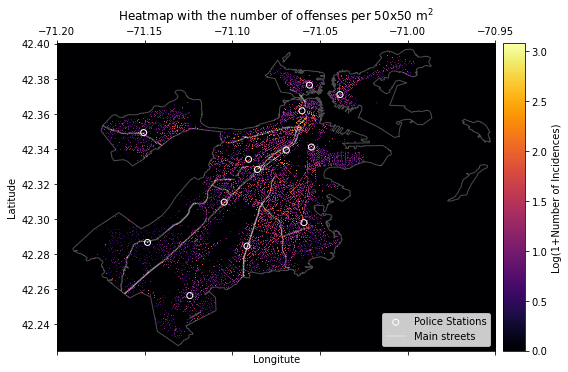

In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt

# Plot the map with the binned crime coordinates and the discretization grid
fig, ax = plt.subplots(figsize=(8,6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Heatmap
img = ax.matshow(np.log10(1+heatmap), origin='lower', extent=(min(long), max(long), min(lat), max(lat)), cmap='inferno')
plt.colorbar(img, cax=cax, label='Log(1+Number of Incidences)')

# Boston outline
boston = gp.GeoSeries(cascaded_union(police['geometry']))
boston.plot(edgecolor='w', ax=ax, facecolor='none', alpha=0.3)

# Police stations
pstat.plot(ax=ax, alpha=1, label='Police Stations', marker='o', fc='none', ec='w')

# Plot streets
street = ['Washington', 'Blue Hill', 'Boylston', 'Harrison', 'Centre']
streets[streets['ST_NAME'].isin(street)].plot(color='w', ax=ax, label='Main streets', alpha=0.3)

# Decoration
ax.set_aspect('equal')
ax.legend(loc='lower right')
ax.set_title(r'Heatmap with the number of offenses per {:d}x{:d} m$^2$'.format(dx,dx))

ax.set_xlabel('Longitute')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

Observations from the heatmap:

* Peaks appear in the heat map (even more dominantly without the log tranformation). I found that they correlate quite well with the location of police stations. 
* Some crimes accumulate along certain streets. A first guess is that these are traffic related incidents.
* Several spots of high crime appear unrelated to streets or police stations e.g. (-71.16, 42.33)

Lets find those crime reports that match exactly the police station location

In [73]:
from shapely.geometry import Point

# Create lookup dict {Station: shapely.Point}
lookup = pstat['geometry'].to_dict()

# Determine if is from a police station
def f(x):
    """Return if distance between points lower than threshold dl"""
    point = Point(x.Long, x.Lat)
    is_station = []
    for key, p in lookup.items():
        if np.sqrt((x.Long-p.x)**2+(x.Lat-p.y)**2) < dl:
            is_station.append(True)
        else:
            is_station.append(False)
        
    return any(is_station)


# Load from file if possible to save time
if not os.path.exists('data/generated/is_station.npz'):

    # Apply
    is_station = crime.apply(f, axis=1)
    
    # Save file
    with open('data/generated/is_station.npz', 'wb') as f:
        np.savez(f, is_station=is_station)

else: 
    
    # Load data
    with np.load('data/generated/is_station.npz', allow_pickle=False) as npz:
        
        is_station = npz['is_station']

In [74]:
# Which categories?
crime[is_station].OFFENSE_CODE_GROUP.value_counts()

crimeDrugViolation                           2098
crimeWarrantArrests                           198
crimeFraud                                    118
crimeFirearmDiscovery                         114
crimeSimpleAssault                            100
crimeVandalism                                 81
crimeLarceny                                   76
crimeViolations                                60
crimeHarassment                                56
crimeVerbalDisputes                            50
crimeConfidenceGames                           47
crimeLarcenyFromMotorVehicle                   38
crimeLiquorViolation                           35
crimeAggravatedAssault                         33
crimeRestrainingOrderViolations                24
crimeFirearmViolations                         22
crimeCounterfeiting                            19
crimeBallistics                                17
crimeDisorderlyConduct                         16
crimeRobbery                                   15


It seems that these crimes have no direct relation to the police station and can be reasonably removed for further analysis.

In [75]:
# Remove these incidents
crime = crime[~is_station]
print('Remaining observations: ', len(crime))

Remaining observations:  196458


### BOSTON DEMOGRAPHICS dataset - Analysis and preparation

The original dataset is composed of an Excel file with 21 sheets, each containing a feature with demographical data for all of Bostons 23 neighborhoods. Since it was not possible to load this dataset with pandas, I manually created a summary with potentially interesting features in a single Excel document. It contains mainly population normalized quantities.

In [76]:
# Show some values
demo.head(3)

State  Total Population  demoAgePct0To9  demoAgePct10To19  \
0       Allston             19363        0.028405          0.138976   
1     Back Bay              18176        0.043904          0.089789   
2  Beacon Hill               9751        0.074659          0.033022   

   demoAgePct20To34  demoAgePct35To54  demoAgePct55To64  demoAgePctOvr65  \
0          0.675722          0.088364          0.034860         0.033672   
1          0.412522          0.192452          0.116527         0.144806   
2          0.487950          0.187263          0.094452         0.122654   

   demoFamMarrCou  demoFamMaNoWi  demoFamFeNoHus  demoFamSingle  \
0        0.140777       0.017191        0.056992       0.435961   
1        0.300998       0.009670        0.037561       0.516490   
2        0.270246       0.008794        0.019238       0.533895   

   demoFamSiNoAlo  demoPopWhite  demoPopBlack  demoPopHispanic  demoPopAsian  \
0        0.349079      0.541961      0.061664         0.138098      0.216909   
1        0.135281      0.755447      0.041648         0.081426      0.098702   
2        0.167827      0.834479      0.012614         0.069326      0.061840   

   demoPopOther  demoPovertyRate  
0      0.041368         0.033634  
1      0.022777         0.015223  
2      0.021741         0.007052

In [77]:
# Show features and encoding
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             23 non-null     object 
 1   Total Population  23 non-null     int64  
 2   demoAgePct0To9    23 non-null     float64
 3   demoAgePct10To19  23 non-null     float64
 4   demoAgePct20To34  23 non-null     float64
 5   demoAgePct35To54  23 non-null     float64
 6   demoAgePct55To64  23 non-null     float64
 7   demoAgePctOvr65   23 non-null     float64
 8   demoFamMarrCou    23 non-null     float64
 9   demoFamMaNoWi     23 non-null     float64
 10  demoFamFeNoHus    23 non-null     float64
 11  demoFamSingle     23 non-null     float64
 12  demoFamSiNoAlo    23 non-null     float64
 13  demoPopWhite      23 non-null     float64
 14  demoPopBlack      23 non-null     float64
 15  demoPopHispanic   23 non-null     float64
 16  demoPopAsian      23 non-null     float64
 17 

In [78]:
# Min, max, mean values
demo.describe()

Total Population  demoAgePct0To9  demoAgePct10To19  demoAgePct20To34  \
count         23.000000       23.000000         23.000000         23.000000   
mean       29090.739130        0.073758          0.112365          0.372558   
std        26090.339297        0.044061          0.102486          0.148109   
min          322.000000        0.000000          0.006211          0.074534   
25%        13578.500000        0.039379          0.057035          0.271281   
50%        25586.000000        0.074659          0.089789          0.362110   
75%        36653.000000        0.121019          0.133336          0.481037   
max       125947.000000        0.137165          0.502691          0.675722   

       demoAgePct35To54  demoAgePct55To64  demoAgePctOvr65  demoFamMarrCou  \
count         23.000000         23.000000        23.000000       23.000000   
mean           0.235882          0.099029         0.106409        0.250413   
std            0.108740          0.043863         0.038883        0.100729   
min            0.016330          0.008907         0.005938        0.000000   
25%            0.184668          0.073598         0.096732        0.181131   
50%            0.243370          0.103591         0.112030        0.260559   
75%            0.281612          0.118121         0.127222        0.310523   
max            0.590062          0.220497         0.178632        0.459475   

       demoFamMaNoWi  demoFamFeNoHus  demoFamSingle  demoFamSiNoAlo  \
count      23.000000       23.000000      23.000000       23.000000   
mean        0.036791        0.119695       0.395672        0.153951   
std         0.030176        0.100799       0.140321        0.089653   
min         0.000000        0.000000       0.000000        0.000000   
25%         0.017834        0.041226       0.304730        0.091513   
50%         0.021584        0.081023       0.377135        0.135281   
75%         0.057173        0.170115       0.507853        0.219509   
max         0.113410        0.330476       0.632143        0.349079   

       demoPopWhite  demoPopBlack  demoPopHispanic  demoPopAsian  \
count     23.000000     23.000000        23.000000     23.000000   
mean       0.553338      0.160047         0.152642      0.099351   
std        0.228434      0.195278         0.116196      0.079417   
min        0.067967      0.004854         0.027950      0.000000   
25%        0.475867      0.042906         0.089887      0.037364   
50%        0.563904      0.062742         0.118406      0.075567   
75%        0.716979      0.182329         0.190633      0.154816   
max        0.884047      0.730087         0.574151      0.316250   

       demoPopOther  demoPovertyRate  
count     23.000000        23.000000  
mean       0.034622         0.043478  
std        0.024971         0.051084  
min        0.014885         0.000777  
25%        0.022259         0.011153  
50%        0.030576         0.032390  
75%        0.037332         0.048181  
max        0.139752         0.232510

In [79]:
# Number of NaN entries per feature
demo.isnull().sum()

State               0
Total Population    0
demoAgePct0To9      0
demoAgePct10To19    0
demoAgePct20To34    0
demoAgePct35To54    0
demoAgePct55To64    0
demoAgePctOvr65     0
demoFamMarrCou      0
demoFamMaNoWi       0
demoFamFeNoHus      0
demoFamSingle       0
demoFamSiNoAlo      0
demoPopWhite        0
demoPopBlack        0
demoPopHispanic     0
demoPopAsian        0
demoPopOther        0
demoPovertyRate     0
dtype: int64

The features cover population age, family situation, populations and poverty for each neighborhood. This dataset is complete and does **not** contain invalid datapoints.

In [80]:
# Strip whitespace from states string
demo['State'] = demo['State'].str.strip()

# Make 'State' index for convenience
demo.set_index('State', drop=True, inplace=True)

#### Feature engineering - Diversity indices

From the age and population features one can derive for each a diversity index which could be interesting for futher analysis. Here I will use the Shannon index [https://en.wikipedia.org/wiki/Diversity_index](https://en.wikipedia.org/wiki/Diversity_index).

In [81]:
import numpy as np
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Shannon diversity index
si = lambda p: -np.sum(p*np.log(p))

# Population diversity index
demo['demoPopDiversity'] = demo.filter(regex='demoPop[^Diversity]').apply(si, axis=1)

# Age diversity index
demo['demoAgeDiversity'] = demo.filter(regex='demoAge[^Diversity]').apply(si, axis=1)

### BOSTON NEIGHBOURHOODS districts dataset - Analysis and preparation

This dataset contains cartographic material of the different neighbourhoods and will used to merge `crime` and `demo` dataset. Here is an outline of the data management plan:

![Data Management Plan Picture](img/merging.png)

The dashed connections mean, that data is aggregated in order to obtain the respective variable. 

In [82]:
# Features and encoding
nbrhd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   OBJECTID         26 non-null     int64   
 1   Name             26 non-null     object  
 2   Acres            26 non-null     float64 
 3   Neighborhood_ID  26 non-null     object  
 4   SqMiles          26 non-null     float64 
 5   ShapeSTArea      26 non-null     float64 
 6   ShapeSTLength    26 non-null     float64 
 7   geometry         26 non-null     geometry
dtypes: float64(4), geometry(1), int64(1), object(2)
memory usage: 1.8+ KB


* We are interested in the `Name` and `geometry` features. 
* Note that the `demo` dataset contains only 23 neighborhoods compared to 26 in `nbrhd`.
* Requires merging of some of the districts in `nbrhd`.

The following dataprocessing is required:

1. Match neighborhood names `demo[State]` and `nbrhd[Name]`
1. Idenify the extra neighborhoods in `nbrhd`
1. Define merge rules and merge the geometries

In [83]:
# Set 'Name' index for ease of convenience
nbrhd.set_index('Name', drop=True, inplace=True)

In [84]:
# Identify extra neighborhoods in nbrhd
set(nbrhd.index) - set(demo.index)

{'Bay Village', 'Chinatown', 'Leather District'}

Let's visualize the extra neighborhoods:

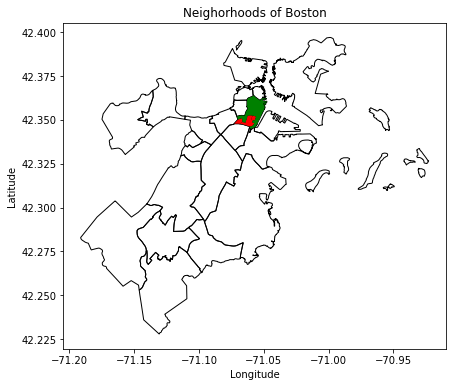

In [85]:
import matplotlib.pyplot as plt

# To which district belong the additional neighborhoods
ax = nbrhd.plot(figsize=(8,6), ec='k', fc='none')
nbrhd.loc[['Bay Village', 'Chinatown', 'Leather District'], :].plot(color='r', ax=ax)
nbrhd.loc[['Downtown'],:].plot(color='g', ax=ax)
plt.title('Neighorhoods of Boston')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

* Quick search on the internet -> assign them to 'Downtown'

In [86]:
# Union of shapely geometries
nbrhd.loc['Downtown','geometry'] = nbrhd.loc[['Bay Village', 'Chinatown', 'Leather District', 'Downtown'],:].unary_union

# Drop old districts
nbrhd.drop(index=['Bay Village', 'Chinatown', 'Leather District'], inplace=True)

Confirm that the new neighborhoods are correct:

<AxesSubplot:>

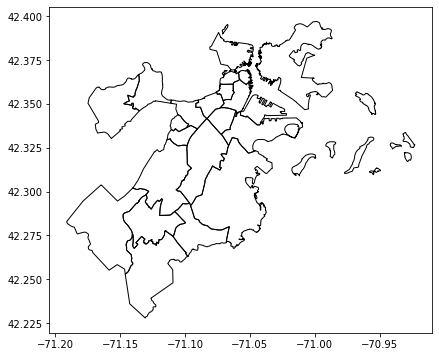

In [87]:
# Checkout new map
nbrhd.plot(figsize=(8,6), ec='k', fc='none')

Finally one can assign each neighborhood in the `demo` dataset the corresponding geometrical shape.

In [88]:
# Assign 'nbrhd' geometry to each district in demographics dataset
demo['geometry'] = nbrhd['geometry']

### ARTIFICIAL DISTRICT dataset - Process and Analyze

The problem with the demographics `demo` dataset is the small number of 23 districts. Hence, the goal is to build a dataset with more districts.

The new districts are created by clustering crimes based on their geographical location into `n_clusters=200` through k-means clustering. 200 districts was found to be a good number to represent every neighborhood from the demographics dataset with at least one datapoint.

In [89]:
from sklearn.cluster import KMeans
import numpy as np
import os

# Number of artificial districts
n_districts = 200

# Unpack X (crime coordinates) / y (crime index)
X = crime[['Lat', 'Long']].values
y = crime.index.values

# Only perform k-means if file doesn't already exists to save time
if not os.path.exists('data/generated/districts_%d.npz' % n_districts):

    # Fit k-means
    kmeans = KMeans(n_clusters=n_districts)
    kmeans.fit(X, y)

    labels = kmeans.labels_
    district_centers = kmeans.cluster_centers_
    
    # Save file
    with open('data/generated/districts_%d.npz' % n_districts, 'wb') as f:
        np.savez(f, labels=kmeans.labels_, district_centers=kmeans.cluster_centers_)

else: 
    
    # Load data
    with np.load('data/generated/districts_%d.npz' % n_districts, allow_pickle=False) as npz:
        
        labels = npz['labels']
        district_centers = npz['district_centers']

In [90]:
# Assign district labels to crimes
crime['District'] = labels

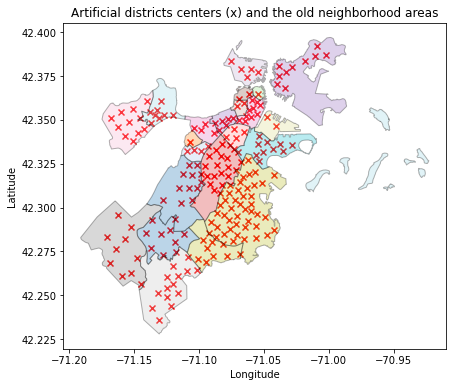

In [91]:
# Checkout the districts center
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(district_centers[:,1], district_centers[:,0], marker='x', c='r')
nbrhd.plot(ax=ax, ec='k', alpha=0.3, column='OBJECTID', cmap='tab20')
plt.title('Artificial districts centers (x) and the old neighborhood areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

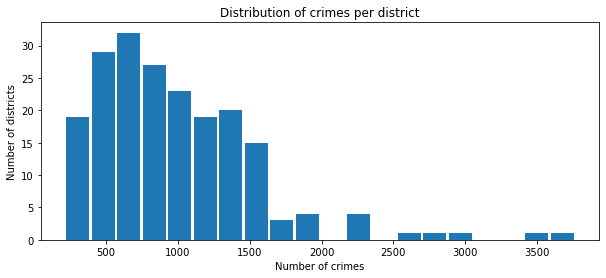

In [92]:
# Crime size distribution of artificial districts
unique, counts = np.unique(labels, return_counts=True)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(counts, rwidth=0.9, bins=20)
ax.set_title('Distribution of crimes per district')
ax.set_xlabel('Number of crimes')
ax.set_ylabel('Number of districts')
plt.show()

The distribution shows that with the current choice of artificial districts there is variation in the new district's crime rate, which later is important to train our models. But at the same time many districts have a crime rate between 200 to 1200 counts. 

#### Create a k-neighbor classifier that predicts district number based on geographic location 

Later it will be necessary to assign geographical points (e.g. location of lights, pubs, etc.) to one of the new districts. 
* One way of defining the area of a district would be to compute the convex hull of all its datapoints (i.e. crimes).
* Another simple solution is to train a K-Neighbors classifier with the district's longitude and latitude to predict the district label. 

I chose the later for simplicity and because it is an easy task to solve with ML.

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Data
X = crime[['Long', 'Lat']].values
y = crime['District']

# Test/Train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Classifier that predicts district
district_knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

# Tune n_neighbors hyperparameter with grid search and cross validation
params = {'n_neighbors': np.r_[1, range(2, 8, 2)]}
district_knn = GridSearchCV(district_knn, params, n_jobs=-1)

# Fit
district_knn.fit(X_train, y_train)

# Best parameters
print('Best estimator params:', district_knn.best_params_)

Best estimator params: {'n_neighbors': 1}


Let's check the accuracy of the best classifier:

In [94]:
# Train score
print('Train score:', district_knn.best_score_)

# Test score
print('Test score:', district_knn.score(X_test, y_test))

Train score: 0.99893672339972
Test score: 0.9992873867453934


Our classifier reaches an accuracy of >99%, which can also be qualitatively shown by a good agreement between predicted boundries and datapoints.

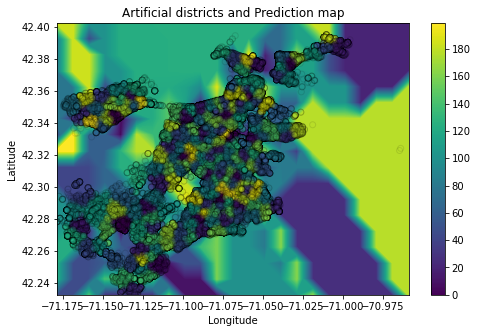

In [95]:
# Decision regions
xx, yy = np.meshgrid(np.arange(X[:,0].min(), X[:,0].max()+0.01, 0.01),
                     np.arange(X[:,1].min(), X[:,1].max()+0.01, 0.01))

# Predict classes
X_pred = district_knn.predict(np.c_[xx.ravel(), yy.ravel()])
X_pred = X_pred.reshape(xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
im = ax.contourf(xx, yy, X_pred, levels=200)
ax.scatter(X[:,0],X[:,1], marker='o', ec='k', c=crime['District'], alpha=0.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Artificial districts and Prediction map')
# zoom = 0.05
# y = 42.27
# x = -71.1
# ax.set_xlim([x-zoom, x+zoom])
# ax.set_ylim([y-zoom, y+zoom])
ax.set_aspect('equal')
plt.colorbar(im)
plt.show()

#### Populate the new district dataframe

The next task is to populate each district with corresponding demographical and geographical data.

In [96]:
# Crate a temporary district dataframe
dist_tmp = pd.DataFrame({'distLong': district_centers[:,1], 'distLat': district_centers[:,0]})
dist_tmp.index.name = 'District'

Due to the scaling problems with geographical coordinate pairs, I use the district ID instead of latitude and longitude.
Source: [https://stackoverflow.com/questions/49743337/conversion-of-latitude-and-longitude-for-fraud-detection-classification-ml](https://stackoverflow.com/questions/49743337/conversion-of-latitude-and-longitude-for-fraud-detection-classification-ml)

In [97]:
# Assign district id as a feature
dist_tmp['distID'] = dist_tmp.index.values

Assign each of the 200 districts a neighborhood from the demographics dataset:

- Check if centroid of the district lies in one of the geometric shape of a neighborhood. 
- Assing it the corresponding neighborhood. 

In [98]:
from shapely.geometry import Point

# Create lookup dict {Neighborhood: shapely.Polygon}
lookup = demo['geometry'].to_dict()

# Assign each crime a neighborhood
def f(x):
    """Return neighborhood if coordinates inside Polygon"""
    point = Point(x.distLong, x.distLat)
    for key, polygon in lookup.items():
        if polygon.contains(point):
            return key

In [99]:
# Assign each district a neighborhood 
dist_tmp['Neighborhood'] = dist_tmp.apply(f, axis=1)

In [100]:
# Print the neighborhoods that have no district assigned -> the fewer the better
set(demo.index.values) - set(dist_tmp.Neighborhood.unique())

{'Harbor Islands'}

With `n_neighbors=200`, all neighborhoods are represented by at least one district. Now the two `demo` and `dist_tmp` dataset can be merged along the `Neighborhood` column.

In [101]:
# Merge the demographics dataset and the districts (Population does not make sense)
dist = pd.merge(dist_tmp, demo.drop(['Total Population','geometry'], axis=1), left_on='Neighborhood', right_index=True, how='left')

#### Feature: Distance police station

Add the distance of a district to the nearest police station as a feature.

In [102]:
# Feature enigneering - Compute distance of district to nearest police station
lookup = pstat['geometry'].to_dict()

# Assign each crime a neighborhood
def f(x):
    """Return distance to the nearest police station"""
    point = Point(x.distLong, x.distLat)
    s = []
    for key, geom in lookup.items():
        s.append((x.distLong-geom.x)**2+(x.distLat-geom.y)**2)
        
    return np.sqrt(min(s))

# Compute the distance
dist['policeDistance'] = dist.apply(f,axis=1)

#### Feature: Street lights counts

Count number of street lights per district.

In [103]:
# Assign street lights to districts with the trained K-Neighbors classifier
lights['district'] = district_knn.predict(lights[['Long', 'Lat']].values)

In [104]:
# Count lights per district
lights_agg = lights.value_counts(subset=['district']).to_frame(name='lightsCount')
lights_agg = lights_agg.reset_index().set_index('district').copy()

#### Features: Event counts - Live Entertainment, Night Club Non-Live Entertainment

Count events in a certain district distingushing between Live Entertainment, Night Club and Non-Live Entertainement.

In [105]:
# Remove Lat, Long outliers
in_lat = (42.225 < events.Lat)  & (events.Lat < 42.4)
in_long = (-71.2 < events.Long) & (events.Long < -70.95)
events = events[(in_lat & in_long)]

Text(57.60631365070681, 0.5, 'Latitude')

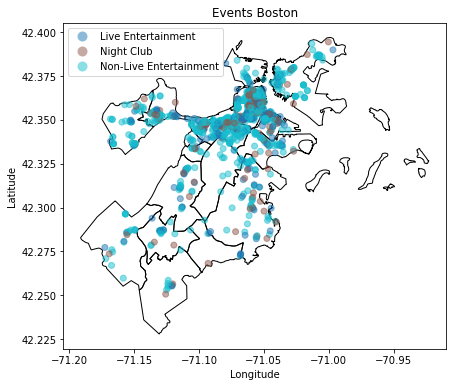

In [106]:
fig, ax = plt.subplots(figsize=(8,6))
nbrhd.plot(ec='k', fc='none', ax=ax)
events.plot(ax=ax, column='license_type', legend=True, categorical=True, alpha=0.5)
ax.set_title('Events Boston')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [107]:
# Assign each event to a district
events['district'] = district_knn.predict(events[['Long', 'Lat']].values)

In [108]:
import helperfunctions as hf

# Count events per district and license_type
events_agg = events.value_counts(subset=['district', 'license_type']).to_frame().copy()

# Pivot
events_agg = events_agg.reset_index(level=1).pivot(columns='license_type')[0].fillna(0)

# Rename columns
events_agg.columns = [hf.camelcase('event_'+s) for s in events_agg.columns]

####  Features: OPENSTREETMAP amenities

Count amenities from openstreetmap for each district.

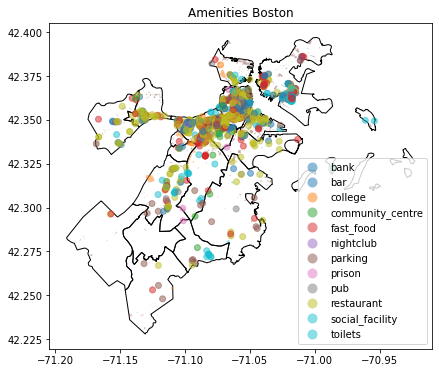

In [109]:
fig, ax = plt.subplots(figsize=(8,6))
nbrhd.plot(ec='k', fc='none', ax=ax)
osmd.plot(ax=ax, column='amenity', legend=True, categorical=True, alpha=0.5)
ax.set_title('Amenities Boston')
plt.show()

In [110]:
# Load aggregated DataFrame from file if available to save time
try:
    osmd_agg = pd.read_csv('data/generated/Boston_Amenities_Per_District_%d.csv' %n_districts, index_col=0)
    
except: 
    # Create a DataFrame with number of amenities vs. district
    osmd_agg = pd.DataFrame(hf.amenities_to_district(osmd, district_knn))
    osmd_agg = osmd_agg.value_counts(subset=['district', 'amenity']).reset_index(level=1).pivot(columns='amenity')[0]
    
    # Fill NaNs with 0
    osmd_agg.fillna(0, inplace=True)
    
    # Save for later
    osmd_agg.to_csv('data/generated/Boston_Amenities_Per_District_%d.csv' %n_districts)

In [111]:
# Rename columns to camelcase
osmd_agg.columns = [hf.camelcase('osmd_'+s) for s in osmd_agg.columns]

In [112]:
# Only 155 out of 200 districts have an amenity entry... that's sad
osmd_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 199
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   osmdBank             161 non-null    float64
 1   osmdBar              161 non-null    float64
 2   osmdCollege          161 non-null    float64
 3   osmdCommunityCentre  161 non-null    float64
 4   osmdFastFood         161 non-null    float64
 5   osmdNightclub        161 non-null    float64
 6   osmdParking          161 non-null    float64
 7   osmdPrison           161 non-null    float64
 8   osmdPub              161 non-null    float64
 9   osmdRestaurant       161 non-null    float64
 10  osmdSocialFacility   161 non-null    float64
 11  osmdToilets          161 non-null    float64
dtypes: float64(12)
memory usage: 16.4 KB


### MASTER dataset - Process and Analyze

This is the dataset contains features and the taraget variable

* Aggregate data from the crime dataset crime counts per crime group per district
* Merge district dataset with aggregated crime
* Target variables: Crimes, Crime rate per district (Let's keep the counts for each crime)

#### Merge datasets: District, OpenStreetMap, Lights and Events 

In [113]:
# Merge district and crime dataset 
df = pd.concat(
    (
        dist.drop('Neighborhood', axis=1),
        osmd_agg,
        lights_agg,
        events_agg
    ), axis=1).fillna(0)

# Sort index
df.sort_index(inplace=True)

#### Create target variable: Crime rate

Let's create a target variable with the crime rate per district. In addition, keep the crime counts per district.

In [114]:
# Count values by district and crime
crime_agg = crime.value_counts(subset=['District', 'OFFENSE_CODE_GROUP']).to_frame().copy()

# Create pivot table district vs. crime with counts
crime_agg = crime_agg.reset_index(level=1).pivot(columns='OFFENSE_CODE_GROUP')[0].fillna(0)

# Convert column headers
# crime_agg.columns = [hf.camelcase('crime_'+col) for col in crime_agg.columns]

# Add crimes
df = df.merge(crime_agg, left_index=True, right_index=True, how='left')

# Create target variable crimeRate (= crimes in a district over entire timespan/total crimes over entire timespan)
df['crimeRate'] = crime_agg.sum(axis=1)
df['crimeRate'].fillna(0, inplace=True)

In [115]:
# Few lines of the new dataset
crime_agg.head(5)

OFFENSE_CODE_GROUP  crimeAggravatedAssault  crimeArson  \
District                                                 
0                                     56.0         0.0   
1                                    138.0         0.0   
2                                     38.0         0.0   
3                                     34.0         0.0   
4                                     97.0         0.0   

OFFENSE_CODE_GROUP  crimeAssemblyOrGatheringViolations  crimeAutoTheft  \
District                                                                 
0                                                  0.0            29.0   
1                                                  2.0            40.0   
2                                                  2.0            24.0   
3                                                  0.0            17.0   
4                                                 11.0            28.0   

OFFENSE_CODE_GROUP  crimeBallistics  crimeBiologicalThreat  crimeBombHoax  \
District                                                                    
0                              12.0                    0.0            0.0   
1                               7.0                    0.0            1.0   
2                               2.0                    0.0            0.0   
3                               3.0                    0.0            0.0   
4                               2.0                    1.0            3.0   

OFFENSE_CODE_GROUP  crimeBurglaryNoPropertyTaken  crimeCommercialBurglary  \
District                                                                    
0                                            0.0                      1.0   
1                                            0.0                      8.0   
2                                            0.0                      3.0   
3                                            0.0                      5.0   
4                                            0.0                     37.0   

OFFENSE_CODE_GROUP  crimeConfidenceGames  ...  crimePropertyRelatedDamage  \
District                                  ...                               
0                                   12.0  ...                         2.0   
1                                   12.0  ...                         7.0   
2                                   18.0  ...                        11.0   
3                                   17.0  ...                         6.0   
4                                   45.0  ...                         8.0   

OFFENSE_CODE_GROUP  crimeProstitution  crimeResidentialBurglary  \
District                                                          
0                                 0.0                      33.0   
1                                20.0                       6.0   
2                                 0.0                      69.0   
3                                 0.0                      34.0   
4                                 0.0                       5.0   

OFFENSE_CODE_GROUP  crimeRestrainingOrderViolations  crimeRobbery  \
District                                                            
0                                              11.0          19.0   
1                                               6.0          75.0   
2                                               8.0          10.0   
3                                               8.0          13.0   
4                                               5.0          66.0   

OFFENSE_CODE_GROUP  crimeSimpleAssault  crimeVandalism  crimeVerbalDisputes  \
District                                                                      
0                                124.0           118.0                195.0   
1                                180.0           121.0                 18.0   
2                                 99.0           111.0                107.0   
3                                 55.0            73.0                105.0   
4                         

In [116]:
# Checkout the new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 86 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   distLong                                   200 non-null    float64
 1   distLat                                    200 non-null    float64
 2   distID                                     200 non-null    int64  
 3   demoAgePct0To9                             200 non-null    float64
 4   demoAgePct10To19                           200 non-null    float64
 5   demoAgePct20To34                           200 non-null    float64
 6   demoAgePct35To54                           200 non-null    float64
 7   demoAgePct55To64                           200 non-null    float64
 8   demoAgePctOvr65                            200 non-null    float64
 9   demoFamMarrCou                             200 non-null    float64
 10  demoFamMaNoWi             

In [117]:
# Min, max, median
df.describe()

distLong     distLat      distID  demoAgePct0To9  demoAgePct10To19  \
count  200.000000  200.000000  200.000000      200.000000        200.000000   
mean   -71.088893   42.318070   99.500000        0.098098          0.114544   
std      0.035908    0.035426   57.879185        0.034478          0.048859   
min    -71.170876   42.236008    0.000000        0.001113          0.024485   
25%    -71.115552   42.288710   49.750000        0.074659          0.084092   
50%    -71.082485   42.318947   99.500000        0.120797          0.130063   
75%    -71.063146   42.347181  149.250000        0.121445          0.136545   
max    -71.001777   42.392289  199.000000        0.137165          0.502691   

       demoAgePct20To34  demoAgePct35To54  demoAgePct55To64  demoAgePctOvr65  \
count        200.000000        200.000000        200.000000       200.000000   
mean           0.330775          0.240948          0.103695         0.111940   
std            0.122251          0.056317          0.027823         0.029623   
min            0.172325          0.016330          0.008907         0.005938   
25%            0.262277          0.231746          0.091287         0.104488   
50%            0.280285          0.259744          0.103591         0.105076   
75%            0.412522          0.268861          0.116527         0.126823   
max            0.675722          0.309323          0.146547         0.178632   

       demoFamMarrCou  ...  crimeProstitution  crimeResidentialBurglary  \
count      200.000000  ...         200.000000                200.000000   
mean         0.277971  ...           0.880000                 33.590000   
std          0.077607  ...           2.636352                 22.080299   
min          0.121429  ...           0.000000                  1.000000   
25%          0.238798  ...           0.000000                 17.750000   
50%          0.260559  ...           0.000000                 29.000000   
75%          0.325160  ...           0.000000                 45.000000   
max          0.459475  ...          20.000000                140.000000   

       crimeRestrainingOrderViolations  crimeRobbery  crimeSimpleAssault  \
count                       200.000000    200.000000          200.000000   
mean                         10.035000     25.575000           98.100000   
std                           8.542167     22.915058           65.637577   
min                           0.000000      1.000000           12.000000   
25%                           4.000000     10.000000           50.000000   
50%                           8.000000     20.500000           86.000000   
75%                          14.000000     33.000000          128.000000   
max                          50.000000    149.000000          420.000000   

       crimeVandalism  crimeVerbalDisputes  crimeViolations  \
count       200.00000           200.000000       200.000000   
mean         95.68000            87.315000        29.680000   
std          44.14011            72.733808        23.597496   
min          17.00000             2.000000         1.000000   
25%          60.00000            26.000000        12.750000   
50%          94.00000            59.000000        23.500000   
75%         127.50000           132.250000        44.000000   
max         239.00000           315.000000       201.000000   

       crimeWarrantArrests    crimeRate  
count            200.00000   200.000000  
mean              47.34000   982.290000  
std               65.42735   563.947105  
min                0.00000   213.000000  
25%               14.00000   582.000000  
50%               27.50000   881.000000  
75%               53.25000  1279.500000  
max              453.00000  3765.000000  

[8 rows x 86 columns]

In [118]:
print('The master dataset has {:d} observables and {:d} features.'.format(*df.shape))

The master dataset has 200 observables and 86 features.


## II. Exploratory Data Analysis

In the following, the EDA is performed to analyze the different datasets and gain a qualtitative understanding of the factors that affect the crime rate in Boston.

### CRIME Dataset

In the coming analysis the following aspects are analysed:

* Spatial distribution of crimes
* Time dependence of crime

#### Most frequent offences/incidents

- Let's find out, which ones are the 15 most frequent offenses:

<AxesSubplot:title={'center':'Offense groups'}, ylabel='Counts'>

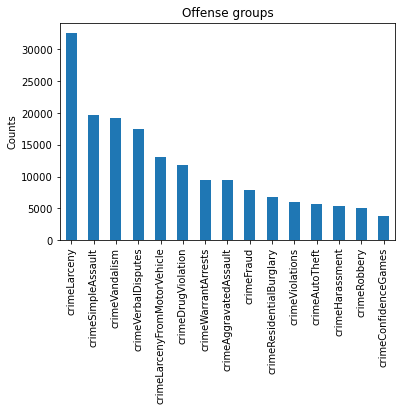

In [119]:
# Counts per offense group
crime.OFFENSE_CODE_GROUP.value_counts().head(15).plot(kind='bar', ylabel='Counts', title='Offense groups')

#### Crime count statistics over districts

Is there a lot of variation in terms of crime count between different districts for each crime group? -> Yes some crimes show a signifiant variation

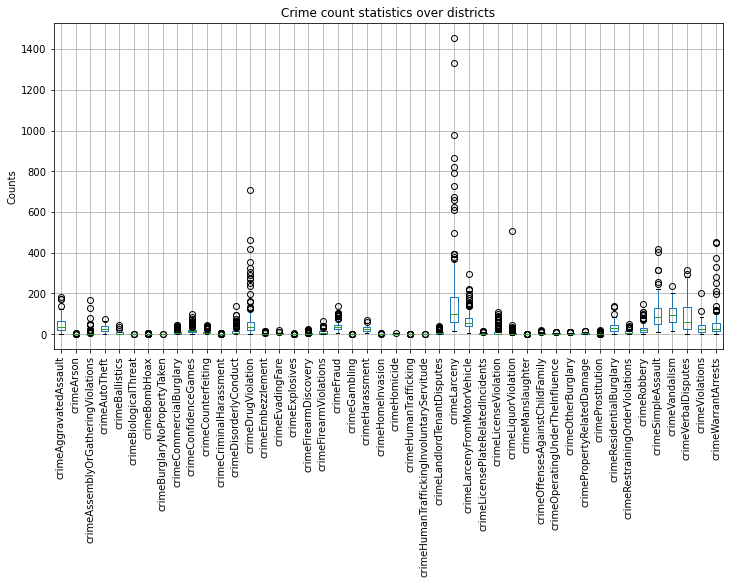

In [120]:
# Crime counts per district
cc = crime.value_counts(subset=['District', 'OFFENSE_CODE_GROUP']).reset_index(level=1).pivot(columns='OFFENSE_CODE_GROUP').fillna(0)[0]

fig, ax = plt.subplots(figsize=(12, 6))
cc.boxplot(rot=90, ax=ax)
ax.set_ylabel('Counts')
ax.set_title('Crime count statistics over districts')
plt.show()

#### Distribution Yearly, Monthly, Weekly, Daily
How is the crime rate distributed over months, weekdays and daytime?

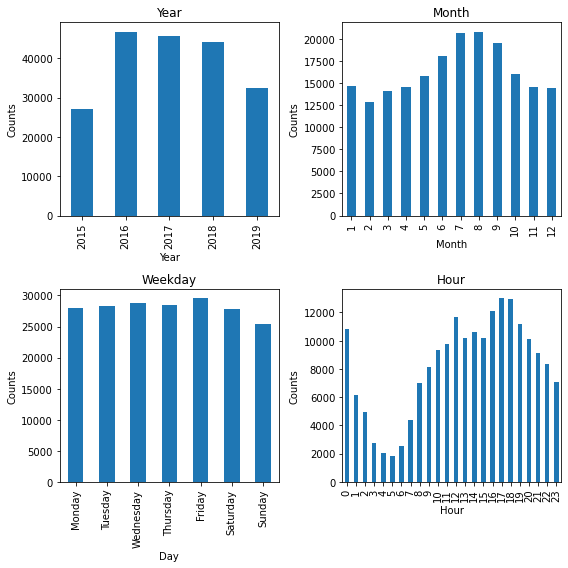

In [121]:
import matplotlib.pyplot as plt

# Create a subplots
fig, axs = plt.subplots(2,2, figsize=(8, 8))
axs = axs.flatten()

# Plot sum of crimes for Year, Month, Day-of-week, Hour
crime.YEAR.value_counts().sort_index().plot(kind='bar', xlabel='Year', ylabel='Counts', title='Year', ax=axs[0])
crime.MONTH.value_counts().sort_index().plot(kind='bar', xlabel='Month', ylabel='Counts', title='Month', ax=axs[1])
crime.DAY_OF_WEEK.value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(kind='bar', xlabel='Day', ylabel='Counts', title='Weekday', ax=axs[2])
crime.HOUR.value_counts().sort_index().plot(kind='bar', xlabel='Hour', ylabel='Counts', title='Hour', ax=axs[3])

plt.tight_layout()
plt.show()

Observations:
* The dataset contains a smaller number of incident in 2015 and 2019. Most likely because the datacollection started in the mid of 2015 and stopped towards the end of 2019. 
* It seems during summer time, the number of incidents increases. 
* Sundays are safer (or just less crowded) than other week days.
* During the night, the number of incidents decreases (except a peak at midnight, maybe an artefact?). Interestingly there is another peak at noon.  

#### Spatial distribution of crimes

- Which are the 15 most dangerous roads?

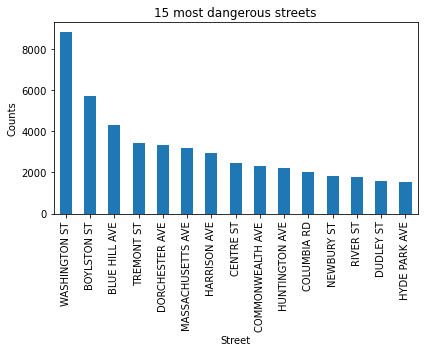

In [122]:
# Create subplots
fig, axs = plt.subplots(1,1, figsize=(6,5))

crime.STREET.value_counts().head(15).sort_values(ascending=False).plot(kind='bar', xlabel='Street', ylabel='Counts', title='15 most dangerous streets', ax=axs)

plt.tight_layout()
plt.show()

Some roads show more crime incidents than others, which could be
1. due to their length or 
1. because they are effectively more dangerous.

Since the crime counts are not normalized to the street length a definitive conclusion is not possible.

#### Spatial distribution of selected crimes

It is also worth to take a look at the spatial distribution of different crime groups: 

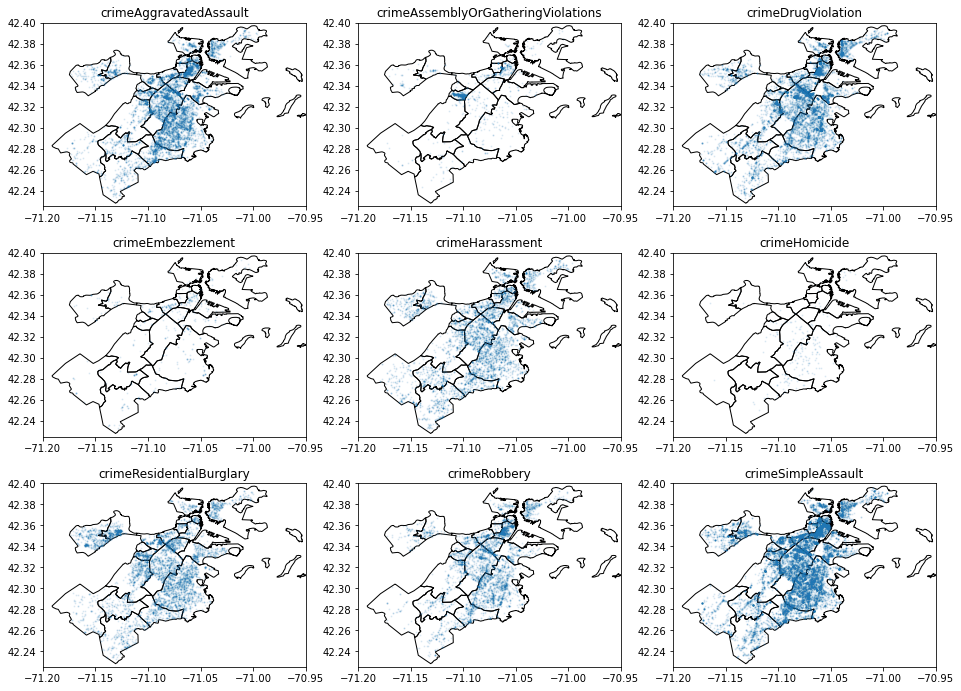

In [123]:
import helperfunctions as hf

# 9 selected crimes
offenses = [
    'crimeAssemblyOrGatheringViolations',
    'crimeAggravatedAssault', 
    'crimeResidentialBurglary',
    'crimeRobbery',
    'crimeDrugViolation',
    'crimeHarassment',
    'crimeHomicide',
    'crimeEmbezzlement',
    'crimeSimpleAssault'
]

hf.scatter_crime_map(crime, offenses, nbrhd)

Ovservations:
* `crimeAssemblyOfGatheringViolations` appear almost excluseively in 2-4 spots. 
* `crimeHarassment` is rather uniformely distributed throughout Boston 
* `crimeDrugViolation` and `crimeRobbery` appear to occur along 3 streets in the southern districts as well as in the districts A1 and D4.
* `crimeResidentialBurglary` does most likely correlate with residential areas. Less counts ccan be observed in the city center.

This observation can also be represended in a histrogram, where it becomes clear how certain crimes are are more uniformely distributed along the districts such as `crimeAggregatedAssault` and others are very local such as `crimeAssemblyOfGatheringViolations`.

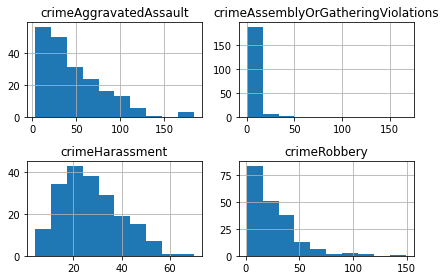

In [124]:
# Different distribution of crime counts within district
cc = crime.value_counts(subset=['District', 'OFFENSE_CODE_GROUP']).reset_index(level=1).pivot(columns='OFFENSE_CODE_GROUP').fillna(0)[0]

crimes_log = cc[['crimeAggravatedAssault', 'crimeAssemblyOrGatheringViolations', 'crimeHarassment', 'crimeRobbery']]
crimes_log.hist()
# cc.hist(column=['crimeAggravatedAssault', 'crimeAssemblyOrGatheringViolations', 'crimeHarassment', 'crimeRobbery'], sharey=True, sharex=True, figsize=(8,8))
plt.tight_layout()
plt.show()

### DEMOGRPAHICS Dataset

I will analyse the demographics dataset in order to find out if there are demographic variations between different districts, which can be used to explain crimes.

An initial guess is that the povery rate will have an influence on crime and it can be shown that some districts have a significantly higher poverty rate than others:

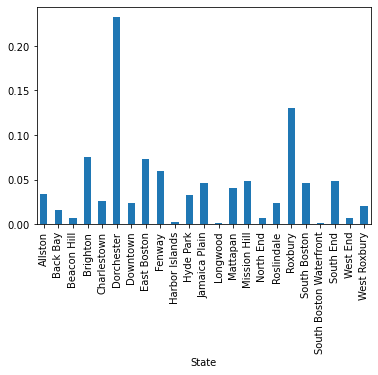

In [125]:
# Poverty rate per district
demo['demoPovertyRate'].plot(kind='bar')
plt.show()

The population composition varies considerabyl between some districts, which intuitively can be another meaningful variable to explain crime rate. A similar trend can be observed for the district's diversity index.

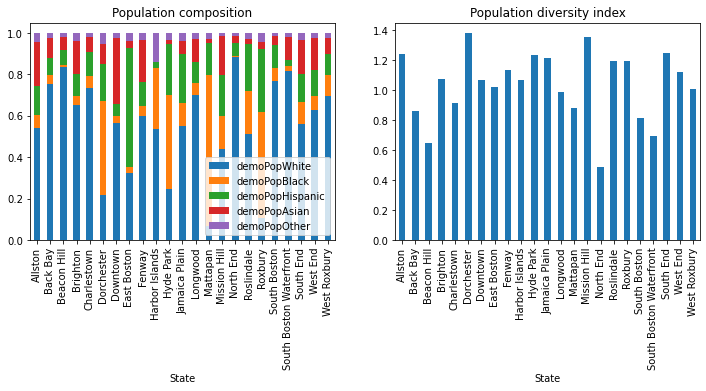

In [126]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Plot peoples composition
demo.filter(regex='demoPop[^Diversity]').plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Population composition')

# Corresponding diversity index
demo['demoPopDiversity'].plot(kind='bar')
ax2.set_title('Population diversity index')
plt.show()

There are also differences in the age composition of the population for the different districts.

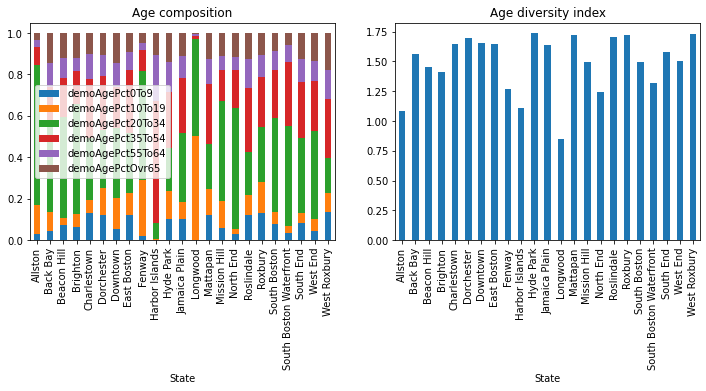

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Plot age composition
demo.filter(regex='demoAge[^Diversity]').plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Age composition')

# Corresponding diversity index
demo['demoAgeDiversity'].plot(kind='bar', ax=ax2)
ax2.set_title('Age diversity index')
plt.show()

### MASTER Dataset

#### District clusters

Good read on TSNE: [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/)

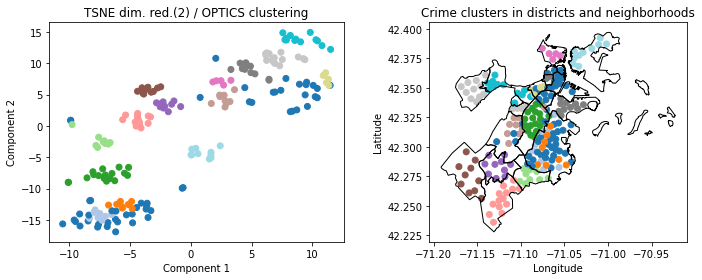

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import OPTICS

# Ideas: https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

# Data
X = df.filter(regex=r'demo|event|distID|osmd|police|light|crimeRate').values

pipe = Pipeline([
    ('scaler', StandardScaler()),
#     ('pca', PCA(2)),
    ('tsne', TSNE(2, perplexity = 30, random_state=0))
])

# Fit and transform 
X_nd = pipe.fit_transform(X)

# Estimate clustering structure
labels = OPTICS().fit_predict(X_nd)

# Plot
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X_nd[:,0], X_nd[:,1], c=labels, cmap='tab20')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('%s dim. red.(2) / OPTICS clustering' % pipe.get_params()['steps'][1][0].upper())


# Plot districts with label
ax2.scatter(district_centers[:,1], district_centers[:,0], marker='o', c=labels, cmap='tab20')
nbrhd.plot(ax=ax2, ec='k', alpha=1, fc='none')#, cmap='tab20')
ax2.set_title('Crime clusters in districts and neighborhoods')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')


plt.tight_layout()
plt.savefig('plots\\%s_%d_and_cluster.png' % (pipe.get_params()['steps'][1][0].upper(), X_nd.shape[1]), dpi=90)
plt.show()

The graph above on the right shows that the clusters of districts form mainly along the neighborhood borders. This is an indication that the coarse granularity of the demographics dataset cannot easily be resolved by creating artificial districts with a finer granularity. 

In the clustering below, the demographics data is removed:

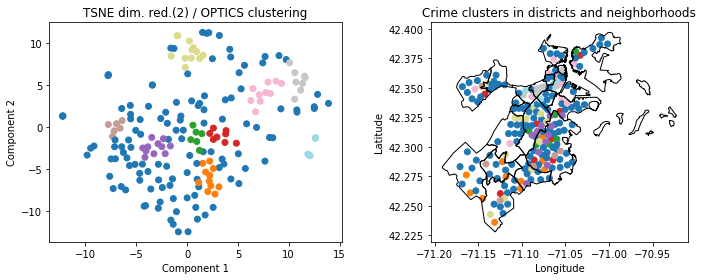

In [129]:
# Data
X = df.filter(regex=r'event|distID|osmd|police|light|crimeRate').values

# Fit and transform 
X_nd = pipe.fit_transform(X)

# Estimate clustering structure
optics = OPTICS()
labels = optics.fit_predict(X_nd)

# Plot
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X_nd[:,0], X_nd[:,1], c=labels, cmap='tab20')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('%s dim. red.(2) / OPTICS clustering' % pipe.get_params()['steps'][1][0].upper())


# Plot districts with label
ax2.scatter(district_centers[:,1], district_centers[:,0], marker='o', c=labels, cmap='tab20')
nbrhd.plot(ax=ax2, ec='k', alpha=1, fc='none')#, cmap='tab20')
ax2.set_title('Crime clusters in districts and neighborhoods')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')


plt.tight_layout()
plt.savefig('plots\\%s_%d_and_cluster.png' % (pipe.get_params()['steps'][1][0].upper(), X_nd.shape[1]), dpi=90)
plt.show()

* Removing demographics data shows that features are not dominated by neighborhood boundaries anymore.
* Yet it's not intuitively clear what these clusters have in common.

#### Correlation of Features

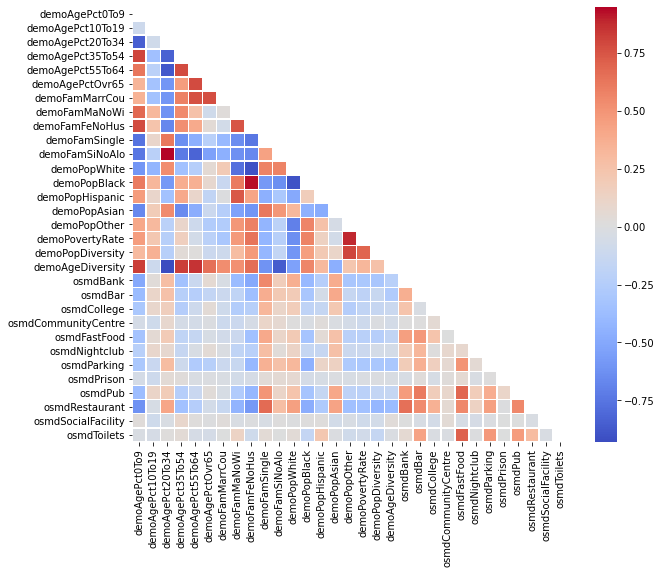

In [133]:
import seaborn as sns

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
corr = df.filter(regex=r'osmd|demo').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, linewidths=0.5, square=True, cmap='coolwarm')
plt.show()

From the correlation map one can see that e.g the demographics feature do not show a high correlation with e.g. the OpenstreetMap features. Combining features that do not correlate can bring in new information into the model.

#### Correlation of some fatures with crimes

The matrix shows that there is a strong correlation between the demographic features, but also some correlation between crimes and the overall crime rate. 
In particular single families, asian population and poverty have a positive correlation with the crime rate. A negative correlation between police distance and crime rate is found.

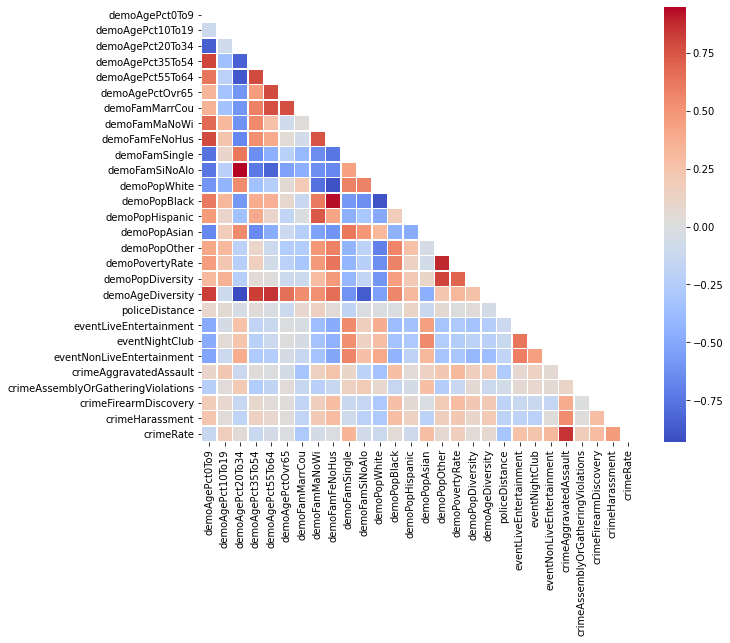

In [134]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
corr = df.filter(regex=r'crimeAggravatedAssault|crimeAssemblyOrGatheringViolations|crimeHarassment|crimeRate|crimeFirearmDiscovery|demo|police|event').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, linewidths=0.5, square=True, cmap='coolwarm')
plt.show()

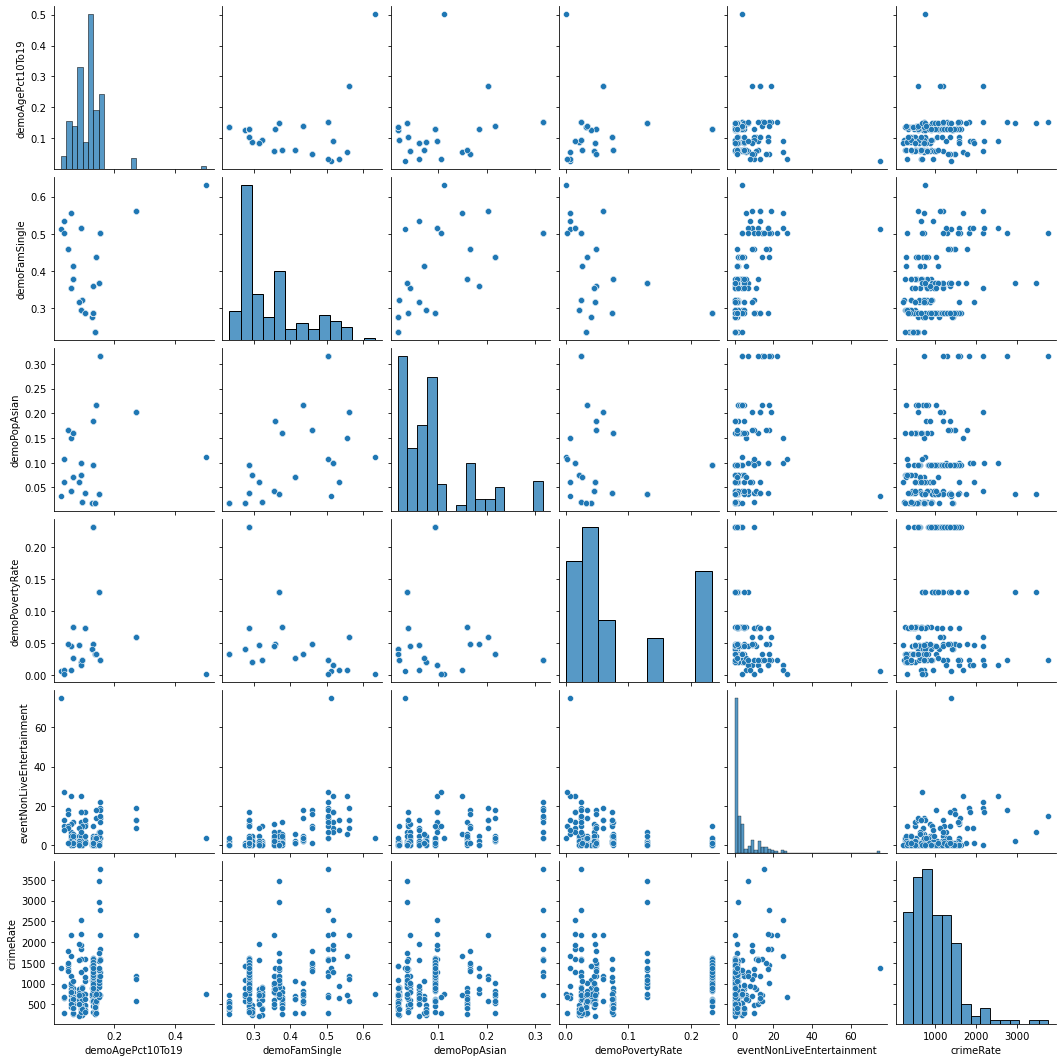

In [135]:
# Pairplot of crime rate and selected features
ff = df.filter(regex=r'crimeRate|Single|Pct10To19|Asian|Poverty|NonLive')
sns.pairplot(ff)
plt.show()

* There is a week linear relation between crime rate and Single families, Asian population.
* The trend for the povery rate is not clear. At high povery rates, one might observe an artefact because of the lack of a finer granularity of the demographics data. (see also distribution function)
* The crime rate also increases with number of non-live events

### Comment on data quality and completeness

#### Summary about data quality

* \>190000 crime observations wtih 46 crime groups in the cleaned dataset
* All other datasets mostly complete
* Low spatial granularity of demographics dataset -> Create artificial districts
* Would have been nice to have information about the person who commited the crime (e.g. age, gender, income, education, etc.)

#### Insights from EDA

- Variation in spatial distribution between different crimes
- Accumulation of crimes close to police stations
- Accumulation of crime along roads, certain neighborhoods
- Strong correlation between features
- There is correlation between crime rate and demographic features. The crime rate linearly increases with percentage of single families, percentage of asian population and poverty rate.
- However due to the low granularity of the demographics data one might see artefacts. 

-> Combining the crime dataset with demographics and public facilities is promising to use ML in order to find out which features determine crime rates.

## III. Machine learning models

* Research question is still: "What characterizes crimes in different Boston locations?"
* Focus is from a quantitative perspective, which features help ML models best forecast crime rates?

In [165]:
# Store results from each estimator
performance = []

# Full features
# df_gs = df.filter(regex=r'distID|demo|police|osmd|lightsCount|event|crimeRate')

# Manual feature selection from feature importances
df_gs = df.filter(regex=r'distID|35to54|55to64|FamNoHouse|Poverty|PopAsian|Distance|Parking|Restaurant|Light|NonLive|crimeRate')

# Get X/y
X = df_gs.drop('crimeRate', axis=1).values # Simple the available features
X_columns = df_gs.drop('crimeRate', axis=1).columns
y = df_gs.crimeRate.values

### Baseline

As a baseline to compare the other regressors I choose the mean strategy, that just predicts the average crime rate for every district.

In [166]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

dummy = DummyRegressor(strategy='mean').fit(X, y)
y_pred = dummy.predict(X)
dummy_score = dummy.score(X, y)

print('Baseline R2 score is : {:.2f}'.format(dummy_score))

performance.append({'estimator': 'Baseline',
                    'mean_test_score' : dummy_score})

Baseline R2 score is : 0.00


### K-Nearest Neighbors

As a first estimator, the K-Neighbors regressor is used 

In [167]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estim', KNeighborsRegressor())
])

# Parameter grid
parameters = {
    'estim__p': [1, 2],
    'estim__n_neighbors': range(4, 28, 4),
}


# Set up GridSearch (cv=10 was too little data per fold)
knn_cv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=4, return_train_score=True)


# Fit 
knn_cv.fit(X, np.log(y))

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estim', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'estim__n_neighbors': range(4, 28, 4),
                         'estim__p': [1, 2]},
             return_train_score=True)

#### K-Nearest Neighbors - Validation curve

It can be seen that for the KNN algorithm, increasing the number of neighbors, decreases the overfitting. 
* Explained by the fact that increasing the number of neighbors includes more data points to determine the decision boundaries -> increase regularization  
* Overfitting of the KNN regressor seems not a big issue above 16 neighbors

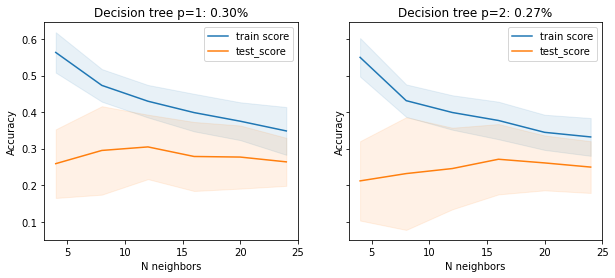

In [168]:
# Plot test and train accuracy
results_df = pd.DataFrame(knn_cv.cv_results_)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for ax, (key, grp) in zip(axs, results_df.groupby('param_estim__p')):

    # Scores
    param_range = range(4, 28, 4)
    mean_train = grp.mean_train_score.values
    std_train = grp.std_train_score.values
    mean_test = grp.mean_test_score.values
    std_test = grp.std_test_score.values


    ax.plot(param_range, mean_train, label='train score', color='tab:blue')
    ax.fill_between(param_range, mean_train - std_train, mean_train + std_train, alpha=0.1, color='tab:blue')
    ax.plot(param_range, mean_test, label='test_score', color='tab:orange')
    ax.fill_between(param_range, mean_test - std_test, mean_test + std_test, alpha=0.1, color='tab:orange')
    ax.set_title('Decision tree p={:d}: {:.2f}%'.format(key, max(mean_test)))
    ax.set_xlabel('N neighbors')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
plt.show()


# Add best results
performance.append({
    'estimator': 'KNN',
    'mean_test_score': knn_cv.cv_results_['mean_test_score'][knn_cv.best_index_],
    'std_test_score': knn_cv.cv_results_['std_test_score'][knn_cv.best_index_],
    'mean_train_score': knn_cv.cv_results_['mean_train_score'][knn_cv.best_index_],
    'std_train_score': knn_cv.cv_results_['std_train_score'][knn_cv.best_index_],
})

### Decision tree

In [169]:
from sklearn.tree import DecisionTreeRegressor

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estim', DecisionTreeRegressor())
])


# Parameter grid
parameters = {
    'estim__max_depth': range(2, 6)
}


# Set up GridSearch (cv=10 was too little data per fold)
tree_cv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=5, return_train_score=True, refit=True)


# Fit 
tree_cv.fit(X, np.log(y))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estim', DecisionTreeRegressor())]),
             n_jobs=-1, param_grid={'estim__max_depth': range(2, 6)},
             return_train_score=True)

#### Decision tree - Validation curve

The train score of the decision tree estimator increases with the tree depth in contrast to the test score, which is a clear sign of overfitting due to a high model complexity. 

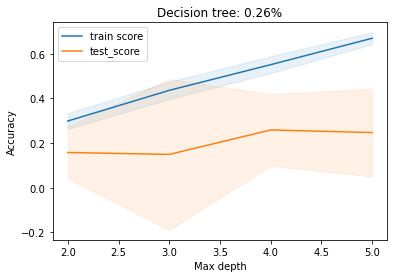

In [170]:
# Plot test and train accuracy
results_df = pd.DataFrame(tree_cv.cv_results_)

# Scores
param_range = range(2, 6)
mean_train = results_df.mean_train_score.values
std_train = results_df.std_train_score.values
mean_test = results_df.mean_test_score.values
std_test = results_df.std_test_score.values

# Plot
fig, ax = plt.subplots()
ax.plot(param_range, mean_train, label='train score', color='tab:blue')
ax.fill_between(param_range, mean_train - std_train, mean_train + std_train, alpha=0.1, color='tab:blue')
ax.plot(param_range, mean_test, label='test_score', color='tab:orange')
ax.fill_between(param_range, mean_test - std_test, mean_test + std_test, alpha=0.1, color='tab:orange')
ax.set_title('Decision tree: {:.2f}%'.format(tree_cv.best_score_))
ax.set_xlabel('Max depth')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
plt.show()

# Add best results
performance.append({
    'estimator': 'Decision tree',
    'mean_test_score': tree_cv.cv_results_['mean_test_score'][tree_cv.best_index_],
    'std_test_score': tree_cv.cv_results_['std_test_score'][tree_cv.best_index_],
    'mean_train_score': tree_cv.cv_results_['mean_train_score'][tree_cv.best_index_],
    'std_train_score': tree_cv.cv_results_['std_train_score'][tree_cv.best_index_],
})

### Random Forest

In [171]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('estim', RandomForestRegressor(max_samples=0.5))
])


# Parameter grid
n_range = np.r_[10, 50, np.arange(100, 700, 200)]
parameters = {
    'estim__n_estimators': n_range,
    'estim__max_depth': [2, 8]
}


# Set up GridSearch (cv=10 was too little data per fold)
forest_cv = GridSearchCV(pipe, parameters, n_jobs=-1, cv=5, return_train_score=True)


# Fit 
forest_cv.fit(X, np.log(y)) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estim',
                                        RandomForestRegressor(max_samples=0.5))]),
             n_jobs=-1,
             param_grid={'estim__max_depth': [2, 8],
                         'estim__n_estimators': array([ 10,  50, 100, 300, 500])},
             return_train_score=True)

#### Random forest - Validation curve

The random forest estimator is heavily overfitting even for low tree depth. As expected the overfitting increases with tree depth. Surprisingly to me, already above `n_estimator=100` the test score saturates and does not increase for `p=2` and `p=8`.

From this graph a few conclusions can be drawn:
* Reducing the depth of the trees mitigates overfitting but negatively affects the accuracy
* According to discussions here [https://stats.stackexchange.com/questions/113177/random-forest-cant-overfit](https://stats.stackexchange.com/questions/113177/random-forest-cant-overfit) the overfitting in my model could be because the model is simple or because of the little number of observations which according to one of the answers.


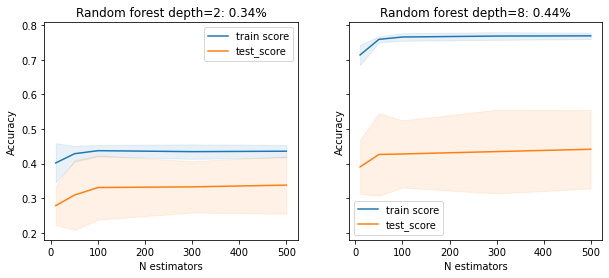

In [172]:
# Plot test and train accuracy
results_df = pd.DataFrame(forest_cv.cv_results_)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for ax, (key, grp) in zip(axs, results_df.groupby('param_estim__max_depth')):

    # Scores
    param_range = n_range
    mean_train = grp.mean_train_score.values
    std_train = grp.std_train_score.values
    mean_test = grp.mean_test_score.values
    std_test = grp.std_test_score.values


    ax.plot(param_range, mean_train, label='train score', color='tab:blue')
    ax.fill_between(param_range, mean_train - std_train, mean_train + std_train, alpha=0.1, color='tab:blue')
    ax.plot(param_range, mean_test, label='test_score', color='tab:orange')
    ax.fill_between(param_range, mean_test - std_test, mean_test + std_test, alpha=0.1, color='tab:orange')
    ax.set_title('Random forest depth={:d}: {:.2f}%'.format(key, max(mean_test)))
    ax.set_xlabel('N estimators')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
plt.show()



# Add best results
performance.append({
    'estimator': 'Random forest',
    'mean_test_score': forest_cv.cv_results_['mean_test_score'][forest_cv.best_index_],
    'std_test_score': forest_cv.cv_results_['std_test_score'][forest_cv.best_index_],
    'mean_train_score': forest_cv.cv_results_['mean_train_score'][forest_cv.best_index_],
    'std_train_score': forest_cv.cv_results_['std_train_score'][forest_cv.best_index_],
})

### ML model accuracy summary

* The random forest estimator performs slightly better in terms of test score than the other two.
* KNN model performs best in terms of overfitting

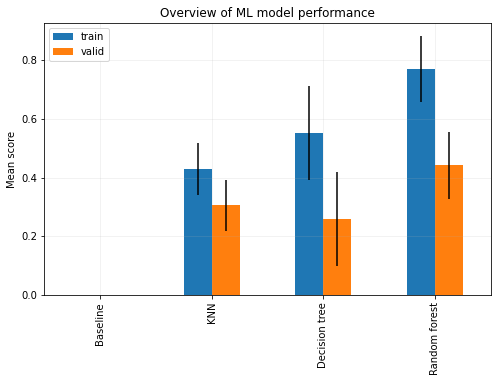

In [173]:
df_compare = pd.DataFrame(performance)
fig, ax = plt.subplots(figsize=(8,5))
ax = df_compare.plot(x='estimator', y=['mean_train_score', 'mean_test_score'], yerr='std_test_score', kind='bar', stacked=False, ax=ax)
ax.set_title('Overview of ML model performance')
ax.set_ylabel('Mean score')
ax.set_xlabel('')
ax.grid(alpha=0.2, zorder=1000)
ax.legend(['train', 'valid'], loc='upper left')
plt.show()

## IV. Discussion

The validation accuracy of the three ML models is below 50%. Since we have no test data, the test accuracy cannot be determined directly. Yet, the cross-validation strategy gives an estimation of the predictive power of the models. A possible explanation for the low validation score is that: 
1. Crime is a complex and multi-facetted problem. Likely, the dataset covers only a few explanatory features relevant to city crimes. Hence our models cannot fully explain the observed crime rates because of the lack of a complete feature set.
1. The target variable `crimeRate` is the sum of different crimes. In the EDA we saw that some crimes are uniformely distributed through the city, while others appear in clusters. We take geographic proximity of crimes to districts into account through the `distID`. However it is hard to believe that one single parameter can account for the complex distributon of the crimes. 
1. A crime count in a district is made up of different subcrimes. In order to better distinguish between crime group rates one could use a MultiOuputRegressor.
1. No significant improvement of the model performance or overfitting can be obtained by using only the principal components from the TSNE instead of using all featues. For interpretability purposes I decided to use the individual features. 

Despite, our estimators predict the the observations better than the mean baseline.

### Model interpretation

#### KNN

Our analysis focuses on the interpretability of the ML model, because we would like to be able to explain which features correlate with a high or low crime rate. KNN shows a better performance in terms of overfitting. However its results are more difficult to interprete, since we cannot a priori visualize an decision rule or the importance of features that explain the data as with decision trees and random forest estimators.

#### Decision Tree

One can obtain the following information from the decision tree regressor:

* The root node represent the entire population with an average crime rate of 982
* The first split criteria is the percentage of Asian population in a district. From the correlation map above, it makes sense that this feature is important. 
* Below a certain percentage of Asian people in a district, the average crime rate is lower i.e. 921 for the majority of districts and above, the average rate is higher i.e. 2948. 

For police distance and number of non-live events the splitting rules can be interpreted similary.

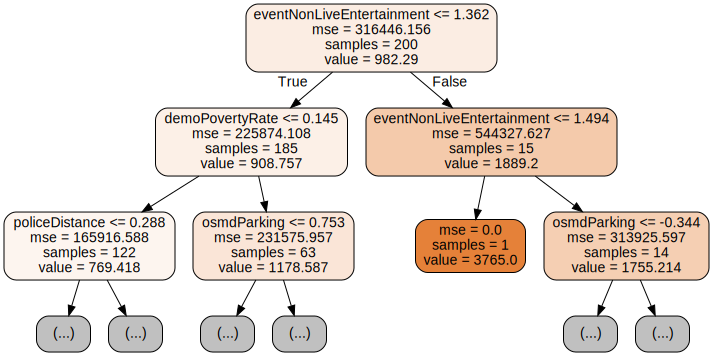

In [174]:
from sklearn.tree import export_graphviz
import graphviz

# Pipeline
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('estim', DecisionTreeRegressor(max_depth=4))
])

clf = clf.fit(X, y)

dot_data = export_graphviz(clf.steps[1][1], 
                           out_file=None, 
                           feature_names=X_columns,  
                           filled=True, rounded=True, max_depth=2
                           )  
graph = graphviz.Source(dot_data)
graph

#### Random Forest

Wiht the random forest regressor it is possible to determine the most important features. After a manual preselection 7 dominant features have been identified for the crime rate as shown below.

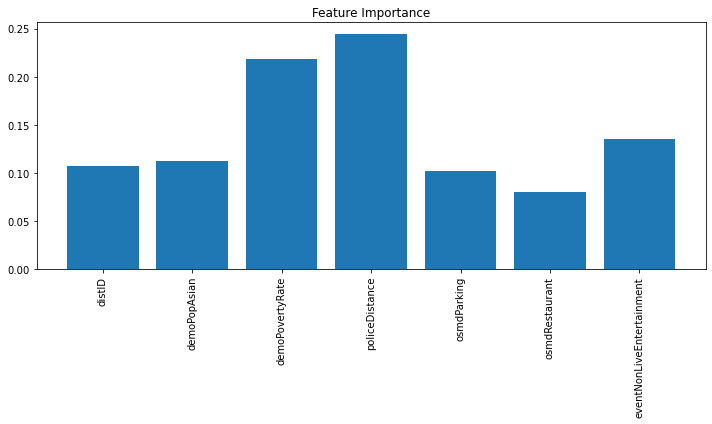

In [175]:
# Plot importance of features
importance = forest_cv.best_estimator_.steps[1][1].feature_importances_
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(X_columns, importance)
plt.xticks(rotation=90)
ax.set_title('Feature Importance')
plt.tight_layout()

#### Predicting crime rate

In order to test the plausibility of our model, I will use the easily understanable feature `demoPovertyRate` and observe its impact on the crime rate. Let's consider we are Mayor of Boston and would like to reduce the crime rate. We could ask ourselves the question: **"Which crime rate could be expected e.g. by putting effort in reducing the poverty in Boston by 50% or even 100%?"**

Answer:
* Graph shows that according to the random forest model, many districts could expect lower crime rates when eliminating poverty. But other factors affect crime and therefore such an effort could not totally eliminate crime. 
* In addition, some districts would see an increase in crime, which intuitively would not make sense. This could be also due to the low prediction accuracy of the model.

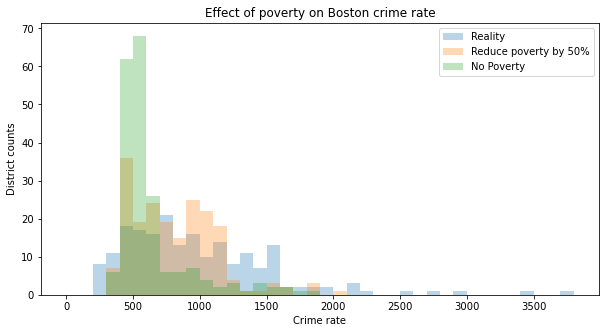

In [178]:
df_tree = df_gs.copy()

# Imagine there would be no poverty in Boston

# Get X/y
df_tree['demoPovertyRate'] = df_gs['demoPovertyRate']*0.5
X_50 = df_tree.drop('crimeRate', axis=1).values
df_tree['demoPovertyRate'] = df_gs['demoPovertyRate']*0.
X_00 = df_tree.drop('crimeRate', axis=1).values

# Current state and predictions
crime_rate = df_tree['crimeRate'].values
crime_pred_50 = forest_cv.predict(X_50)
crime_pred_00 = forest_cv.predict(X_00)

# Plotting
plt.figure(figsize=(10,5))
bins = np.arange(0, crime_rate.max()+100, 100)
plt.hist(crime_rate, bins=bins, label='Reality', alpha=0.3, fc='tab:blue')
plt.hist(np.exp(crime_pred_50), bins=bins, label='Reduce poverty by 50%', alpha=0.3)
plt.hist(np.exp(crime_pred_00), bins=bins, label='No Poverty', alpha=0.3)
plt.legend(loc='best')
plt.title('Effect of poverty on Boston crime rate')
plt.xlabel('Crime rate')
plt.ylabel('District counts')
plt.savefig('img/poverty_vs_crime.png')
plt.show()

## V. Conlcusion

In conclusion, the analysis of Bostons crimes gave insights into the origins of crime with the features available and it was possible to quantitatively describe the relation of these features with the crime rate. However, despite the apparent abundance of data, more variables with high granularity are needed in order to explain the crimes. The low accuracy of the models is a clear indication that not all variables to explain the data are available.
The overall crime rate might not be the best target variable because of large variation in crime counts per crime group within a district exists. A possiblity to refine the model could be to do MultiTargetRegression. 